In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth

import timeit
import ODE_utils as odeu
from scipy import optimize
import tables
#from mpmath import *
#!jt -t -cellw 100%

In [2]:
###Initial Values###

M0=1.0
Q=0.95
Lambda=0.01#0.001#0.0001#0.1#0.14#0.1#0.1
scalarfield=False
A=.025#.115
vscalarfield=False


In [3]:
Tol=0.5#.025#.05
N=50
Nul=50
Nup=10**(60)
scal=20
uscal=10
umax=40
vmax=50
extraterms=True
rcosmtol=.0001#.0000000000000001
dpower=1.0

datatype=np.float64


#ru0=5.0
#dr0v=.4
ru0=5.0
#dr0v=0.045
dr0v=0.5*(1-2*M0/ru0+Q**2.0/ru0**2.0-Lambda/3*ru0**2.0)#0.05#-1/(4*-.375)*(1-2*M0/ru0+Q**2/ru0**2-Lambda*ru0**2/3)

#dr0v=.075

vbdytype="edd"
ubdytype="stan"
scaltostan=False
solveaffine=False

Elist=[1]
#Elist=[1,2,4,8,16]
if vbdytype=="edd":
    dr0v=0.5*(1-2*M0/ru0+Q**2.0/ru0**2.0-Lambda/3*ru0**2.0)
    dpower=0.5*np.exp(-vmax/50)+1.0#1.5*(vmax/100)^(-1)
    if Lambda>0.0:
        dpower=.1*np.exp(-vmax/100)+1.0#1.5*(vmax/100)^(-1)
        dpower=1.0
#uloc=[1/8,1/4,3/8,1/2,5/8]
#uloc=[1/5,2/5,3/5,4/5,9/10]
uloc=[8.2/10]
print(dr0v)
print(dpower)

0.2763833333333333
1.0


In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    dv0=1/N    
else:
    dv0=M0/N
    


def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

if Lambda>0 or Lambda<0:
    sol = optimize.root(fr,[0.687,1.3,500.0],args=(M0,Q,Lambda), method='hybr')
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=sol.x[2]
else:
    rplus=M0+(M0**2-Q**2)**(.5)
    rminus=M0-(M0**2-Q**2)**(.5)
    rcosm=0.0
    

wHD=True 

print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

print("Max r along u=0: "+str(ru0+vmax*dr0v))
###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=Nul*umax#int(umax/du0)
Nv=int(vmax/dv0)
#print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=Nu*Nv

print("Total number of points is "+str(int(numpoints)))

predtime=numpoints/(1700000)

print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")


r+: 1.328453333041486
r-: 0.6865663660958414
rc: 16.251309434683108
Max r along u=0: 18.819166666666668
Number of points for highest iteration is 5000000,2000X2500
Total number of points is 5000000
Runtime: about 0.05 minutes


In [5]:
print((rplus-rminus)/(2*rminus)*rcosm/rminus)

11.065011595879565


In [6]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])


rnpf=np.zeros((2,Nv),dtype=datatype)
signpf=np.zeros((2,Nv),dtype=datatype)
phinpf=np.zeros((2,Nv),dtype=datatype)
drnpvf=np.zeros((2,Nv),dtype=datatype)
dsignpvf=np.zeros((2,Nv),dtype=datatype)
dphinpvf=np.zeros((2,Nv),dtype=datatype)
drnpuf=np.zeros((2,Nv),dtype=datatype)
dsignpuf=np.zeros((2,Nv),dtype=datatype)
dphinpuf=np.zeros((2,Nv),dtype=datatype)
massnpf=np.full((2,Nv),M0)#np.zeros((2,Nv))
#drunpv=np.full((1,Nv-1),-1/(4*dr0v)*(1-2*M0/ru0+Q**2/ru0**2))
 


rnpf[0], signpf[0], phinpf[0] , drnpvf[0], dsignpvf[0], dphinpvf[0], drnpuf[0], dsignpuf[0], dphinpuf[0] , massnpf[0]= odeu.boundaryv(scal,ubdytype,vbdytype,Nv,ru0,dr0v,dv0,vmax,M0,Q,Lambda,scalarfield,A,rcosmtol,datatype)


mask=~np.isnan(rnpf[0])
#print(mask)
rnpf=rnpf[:,mask]
#print(rnpf)
Nv=int(len(rnpf[0]))
rnpf=rnpf.reshape(2,Nv)
signpf=signpf[:,mask]#.reshape(2,Nv)
phinpf=phinpf[:,mask]#.reshape(2,Nv)
dphinpuf=dphinpuf[:,mask]#.reshape(2,Nv)  
dphinpvf=dphinpvf[:,mask]#.reshape(2,Nv)
dsignpuf=dsignpuf[:,mask]#.reshape(2,Nv)
dsignpvf=dsignpvf[:,mask]#.reshape(2,Nv)
drnpuf=drnpuf[:,mask]#.reshape(2,Nv)
drnpvf=drnpvf[:,mask]#.reshape(2,Nv)
massnpf=massnpf[:,mask]#.reshape(2,Nv)

#print(massnpf)

2500
[ 5.          5.00552856  5.01105888 ... 14.68547079 14.68696131
 14.68845051] 2500


In [7]:
#print(rnpf)
print(len(rnpf[0]))
print(Nv)
#print(signpf)

2500
2500


2500 2500 50.0
2500


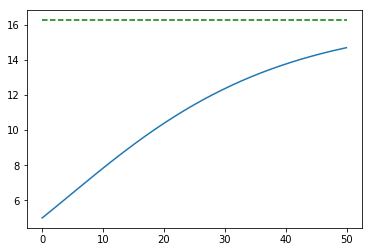

1.0000000000067468 16.25130943467495
-0.2763833333333333
[[0.27638333 0.27647219 0.27656061 ... 0.07455945 0.07449297 0.07442654]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [8]:
vmax=(Nv)*dv0

print(Nv,len(rnpf[0]),vmax)

vrange=np.arange(0,vmax-.00000001*vmax,dv0)#*rnpf[0])/rnpf[0]
print(len(vrange))
#print(vrange)
        
plt.plot(vrange,rnpf[0])
#plt.plot(dphinpvf[0])
#plt.plot(dphinpuf[0])
Mc=np.nanmax(massnpf[0])
rcosm=odeu.rc(Mc,Q,Lambda)
plt.plot([0,vmax],[rcosm,rcosm],linestyle='--',color='green')
plt.show()



#print(vrange)
print(Mc,rcosm)
print(drnpuf[0,0])

print(drnpvf)

In [9]:
drunptemp=np.empty((Nv))*np.nan
#dsigunp=np.empty((Nu))*np.nan


A=.115
u1=9.5
u2=10

###Applying Propagation Algorithm###

urange=np.array([0.0],dtype=datatype)

massnpf[0][0]=1.0

#drunp[0]=-mth.exp(signpf[0][0])/(4.0*dr0v)*(1-2*M0/ru0+Q**2.0/ru0**2.0-Lambda*ru0**2/3)
#dsigunpvalue=100*np.exp(np.nanmax(signpf))
#drunptemp=drunp[0]
    

i=0
icount=0
dv=dv0
if M0>0:
    du0=M0/Nul
elif M0==0:
    du0=1/Nul

du=du0

###fix this part (put in front of boundary conditions so it is an initial condition)
#if bdytype=="edd" or bdytype=="fulledd":
    #bdyvalue=1.0
    #dsignpuf[0]=2*(3*Q**2-3*M0*ru0+ru0**4*Lambda)/(ru0*(-3*Q**2+ru0*(6*M0-3*ru0+ru0**3*Lambda)))*drunp[0]
    #dsigunp[0]=2.0*(M0*rnpf[0]-Q**2.0)/(rnpf[0]*(Q**2.0+rnpf[0]*(-2*M0+rnpf[0])))*drunp[0]
#else:
    #bdyvalue=0.0
    #dsigunp[0]=0.0
######
    
atom = tables.Float64Atom()

rnpfile = tables.open_file('rnp.h5', mode='w',encoding="utf8") 
rnp = rnpfile.create_earray(rnpfile.root, 'data', atom, (0, Nv))

signpfile = tables.open_file('signp.h5', mode='w',encoding="utf8") 
signp = signpfile.create_earray(signpfile.root, 'data', atom, (0, Nv))
phinpfile = tables.open_file('phinp.h5', mode='w',encoding="utf8") 
phinp = phinpfile.create_earray(phinpfile.root, 'data', atom, (0, Nv))
massnpfile = tables.open_file('massnp.h5', mode='w',encoding="utf8") 
massnp = massnpfile.create_earray(massnpfile.root, 'data', atom, (0, Nv))

if extraterms==True:
    drnpufile = tables.open_file('drnpu.h5', mode='w',encoding="utf8") 
    drnpu = drnpufile.create_earray(drnpufile.root, 'data', atom, (0, Nv))
    drnpvfile = tables.open_file('drnpv.h5', mode='w',encoding="utf8") 
    drnpv = drnpvfile.create_earray(drnpvfile.root, 'data', atom, (0, Nv))
    dsignpufile = tables.open_file('dsignpu.h5', mode='w',encoding="utf8") 
    dsignpu = dsignpufile.create_earray(dsignpufile.root, 'data', atom, (0, Nv))
    dsignpvfile = tables.open_file('dsignpv.h5', mode='w',encoding="utf8") 
    dsignpv = dsignpvfile.create_earray(dsignpvfile.root, 'data', atom, (0, Nv))
    dphinpufile = tables.open_file('dphinpu.h5', mode='w',encoding="utf8") 
    dphinpu = dphinpufile.create_earray(dphinpufile.root, 'data', atom, (0, Nv))
    dphinpvfile = tables.open_file('dphinpv.h5', mode='w',encoding="utf8") 
    dphinpv = dphinpvfile.create_earray(dphinpvfile.root, 'data', atom, (0, Nv))
    
    
 
#rtemp=rnpf[0]   
#print(rtemp)
rnp.append(rnpf[0].reshape(1,Nv))
signp.append(signpf[0].reshape(1,Nv))
phinp.append(phinpf[0].reshape(1,Nv))
massnp.append(massnpf[0].reshape(1,Nv))

#drunp=np.append(drunp,np.nan)
#dsigunp=np.append(dsigunp,np.nan)
#dphinpuf=np.append(dphinpuf,np.nan)
drunptemp=np.nanmax(np.abs(drnpuf[0]))     
dsigunpvalue=np.nanmax(np.abs(dsignpuf[0]))
dphiutemp=np.nanmax(np.abs(dphinpuf[0]))

rnpf[1][0]=rnpf[0][0]

i=0
TempTol=1 
TempTolv=1
Eres=False
if ubdytype=='adapt':
    maxsig1=signpf[0][0]-np.nanmax(signpf[0])
    maxsig2=signpf[0][0]-np.nanmax(signpf[0])
    maxsig3=signpf[0][0]-np.nanmax(signpf[0])
    print(maxsig1,maxsig2,maxsig3)
    

while max(urange)<umax and i<200000 and du>0.0: #and rnpf[1][0]>0.0 :

    
    du=du0*Tol*TempTol/(np.nanmax([abs(dsigunpvalue),abs(drunptemp),abs(dphiutemp)]))**(dpower)
    #du=du0*Tol*TempTol/(np.nanmax(np.abs(dsigunpvalue*drunptemp)))**(dpower)
    #du=du0*Tol*TempTol/(np.nanmax(np.abs(dsignpuf[0]*drnpuf[0]-rnpf[0]*dphinpuf[0]**2.0)))**(dpower)
    #du=du0*Tol*TempTol/max([abs(dsigunpvalue),abs(drunptemp),abs(dphiutemp)])

    
    #if du<1/Nup*1.1:
        #du=1/Nup
     
    du=np.min([du,1/(1*Nul)])
    #if du>=1/Nul:
        #print('r='+str(rnpf[i][0]))
        #if rnpf[1][0]<rplus:
            #du=1/(1*Nul)
            #print(rplus)
        #else:
            #du=1/Nul
    

    #print("%.24f" % urange[i])
    #print("%.24f" % du)
    
    ###fix this section (dphinpuf is in the wrong form)
    #if urange[i]>u1 and urange[i]<u2 and vscalarfield==True:
        #u=urange[i]+du
        #phinpf[1][0]=A*64*(u-u1)**3.0*(u2-u)**3.0/(u2-u1)**6.0
        #dphinpuf[i]=192*A*(u-u1)**2.0*(u-u2)**2.0*(-2*u+u1+u2)/(u1-u2)**6.0 
    #else:
        #continue
        #phinpf[1][0]=0.0
        #dphinpuf[i+1]=0.0
    

    ###Predictor###
    drnpvf[1]=drnpvf[0]+du*odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)
    if ubdytype=='adapt':
        nextsig=(maxsig1*3.0-maxsig2*3.0+maxsig3*1.0)
        #print(nextsig,signpf[0][0])
        dsignpuf[1][0]=-np.nanmax(np.abs(dsignpuf[0]))/Nul#*du#2*(nextsig-signpf[0][0])/du-dsignpuf[0][0]
        #print(nextsig,dsignpuf[1][0])
        #dsignpuf[1][0]=-(signpf[1][-1]-np.log(drnpvf[1][-1])+3/2*np.log(2))
    
    dsignpvf[1]=dsignpvf[0]+du*odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)
    dphinpvf[1]=dphinpvf[0]+du*odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])
    drnpuf[1]=drnpuf[0]+du*odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])
    
    rnpf[1]=rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    
    #signpf[1][0]=nextsig
    #signpf[1]=signpf[1][0]+1/2*dv*(np.cumsum(dsignpvf[1]+np.roll(dsignpvf[1],1))-(dsignpvf[1][0]+np.roll(dsignpvf[1],1)[0]))
    signpf[1]=signpf[0]+du*dsignpuf[0]
    phinpf[1]=phinpf[0]+du*dphinpuf[0]
    
    #drnpvf[1][0]=drnpvf[0][0]+du*odeu.Rfunc(drnpvf[0][0],drnpuf[0][0],rnpf[0][0],signpf[0][0],Q,Lambda)
    #drnpvf[1][0]=-1/(4*drnpuf[1][0])*np.exp(signpf[1][0])*(1-2*M0/rnpf[1][0]+Q**2/rnpf[1][0]**2-Lambda*rnpf[1][0]**2/3)
    #drnpvf[1]=drnpvf[1][0]*np.exp(signpf[1]-signpf[1][0])-np.exp(signpf[1])*(1/2*dv*(np.cumsum(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1])+np.roll(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1]),1))-(rnpf[1][0]*(dphinpvf[1][0])**2.0*np.exp(-signpf[1][0])+np.roll(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1]),1)[0])))
    
    #Rfuncnp=odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda)
    #drnpuf[1]=drnpuf[1][0]+1/2*dv*(np.cumsum(Rfuncnp+np.roll(Rfuncnp,1))-(Rfuncnp[0]+np.roll(Rfuncnp,1)[0]))
    #drnpuf[1]=drnpuf[1][0]+0.5*dv*(np.cumsum(np.roll(odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda),1)+odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda))-(np.roll(odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda),1)[0]+odeu.Rfunc(drnpvf[1][0],drnpuf[1][0],rnpf[1][0],signpf[1][0],Q,Lambda)))
    #rnpf[1]=rnpf[1][0]+1/2*dv*(np.cumsum(drnpvf[1]+np.roll(drnpvf[1],1))-drnpvf[1][0]-np.roll(drnpvf[1],1)[0])
    
    #for j in range(0,Nv-1):
        #drnpvf[1][j+1]=drnpvf[1][j]+dv*odeu.Coneq(drnpvf[1][j],dsignpvf[1][j],dphinpvf[1][j],rnpf[1][j])
        #drnpvf[1][j+1]=drnpvf[1][j]+0.5*(dv*odeu.Coneq(drnpvf[1][j],dsignpvf[1][j],dphinpvf[1][j],rnpf[1][j])+dv*odeu.Coneq(drnpvf[1][j+1],dsignpvf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1]))
    
    #if np.any(phinpf[1]): 
        #dsignpuf[1][0]=0.0
        #dphinpuf[1][0]=0.0
        #for j in range(0,Nv-1):
            #dphinpuf[1][j+1]=dphinpuf[1][j]+dv*odeu.Phifunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j])         
            #dphinpuf[1][j+1]=dphinpuf[1][j]+1/2*dv*(odeu.Phifunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j])+odeu.Phifunc(drnpvf[1][j+1],drnpuf[1][j+1],dphinpuf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1]))
            #dsignpuf[1][j+1]=dsignpuf[1][j]+dv*odeu.Sigfunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j], rnpf[1][j],signpf[1][j],Q)                                                                             
            #Phifuncnp=odeu.Phifunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1])
    #else:
        #dphinpuf[1]=0.0
    
    #dsignpuf[1][0]=0.0
    #dphinpuf[1][0]=0.0 
    #print(dsignpuf[1])
    #print(dphinpuf[1])
    #if ubdytype=='stan':
        #dsignpuf[1][0]=0.0  
    
    
    dphinpuf[1]=1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-1/2*dv*(np.cumsum(drnpuf[1]*dphinpvf[1]+np.roll(drnpuf[1]*dphinpvf[1],1))-(drnpuf[1][0]*dphinpvf[1][0]+np.roll(drnpuf[1]*dphinpvf[1],1)[0])))
    Sigfuncnp=odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1]=dsignpuf[1][0]+1/2*dv*(np.cumsum(Sigfuncnp+np.roll(Sigfuncnp,1))-(Sigfuncnp[0]+np.roll(Sigfuncnp,1)[0]))
    
    #print(dsignpuf[1])
    #print(dphinpuf[1])
    
    ###Correction###
    drnpvf[1]=drnpvf[0]+1/2*du*(odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)+odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda))
    
    #for j in range(0,Nv-1):
        #drnpvf[1][j+1]=drnpvf[1][j]+dv*odeu.Coneq(drnpvf[1][j],dsignpvf[1][j],dphinpvf[1][j],rnpf[1][j])
        #drnpvf[1][j+1]=drnpvf[1][j]+0.5*(dv*odeu.Coneq(drnpvf[1][j],dsignpvf[1][j],dphinpvf[1][j],rnpf[1][j])+dv*odeu.Coneq(drnpvf[1][j+1],dsignpvf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1]))
    dsignpvf[1]=dsignpvf[0]+1/2*du*(odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)+odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q))
    dphinpvf[1]=dphinpvf[0]+1/2*du*(odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])+odeu.Phifunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1]))
    drnpuf[1]=drnpuf[0]+1/2*du*(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])+odeu.Coneq(drnpuf[1],dsignpuf[1],dphinpuf[1],rnpf[1]))
    
    Rfuncnp=odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda)
    #drnpuf[1]=drnpuf[1][0]+1/2*dv*(np.cumsum(Rfuncnp+np.roll(Rfuncnp,1))-(Rfuncnp[0]+np.roll(Rfuncnp,1)[0]))
    #drnpuf[1]=drnpuf[1][0]+0.5*dv*(np.cumsum(np.roll(odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda),1)+odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda))-(np.roll(odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda),1)[0]+odeu.Rfunc(drnpvf[1][0],drnpuf[1][0],rnpf[1][0],signpf[1][0],Q,Lambda)))
    rnpf[1]=rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    signpf[1]=signpf[0]+1/2*du*(dsignpuf[0]+dsignpuf[1])
    #signpf[1]=signpf[1][0]+1/2*dv*(np.cumsum(dsignpvf[1]+np.roll(dsignpvf[1],1))-(dsignpvf[1][0]+np.roll(dsignpvf[1],1)[0]))
    phinpf[1]=phinpf[0]+1/2*du*(dphinpuf[0]+dphinpuf[1])
    
    
    #drnpvf[1]=drnpvf[1][0]*np.exp(signpf[1]-signpf[1][0])-np.exp(signpf[1])*(1/2*dv*(np.cumsum(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1])+np.roll(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1]),1))-(rnpf[1][0]*(dphinpvf[1][0])**2.0*np.exp(-signpf[1][0])+np.roll(rnpf[1]*(dphinpvf[1])**2.0*np.exp(-signpf[1]),1)[0])))
    #rnpf[1]=rnpf[1][0]+1/2*dv*(np.cumsum(drnpvf[1]+np.roll(drnpvf[1],1))-drnpvf[1][0]-np.roll(drnpvf[1],1)[0])
    
    #########
    #if np.any(phinpf[1]): 
        #dsignpuf[1][0]=0.0
        #dphinpuf[1][0]=0.0
        #for j in range(0,Nv-1):
            #dphinpuf[1][j+1]=dphinpuf[1][j]+1/2*dv*(odeu.Phifunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j])+odeu.Phifunc(drnpvf[1][j+1],drnpuf[1][j+1],dphinpuf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1]))         
            #dsignpuf[1][j+1]=dsignpuf[1][j]+1/2*dv*(odeu.Sigfunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j],signpf[1][j],Q)+odeu.Sigfunc(drnpvf[1][j+1],drnpuf[1][j+1],dphinpuf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1],signpf[1][j+1],Q))    
    #else:
        #dphinpuf[1]=0.0
    #dsignpuf[1][0]=0.0
    #dphinpuf[1][0]=0.0
    ########
    
    
    dphinpuf[1]=1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-1/2*dv*(np.cumsum(drnpuf[1]*dphinpvf[1]+np.roll(drnpuf[1]*dphinpvf[1],1))-(drnpuf[1][0]*dphinpvf[1][0]+np.roll(drnpuf[1]*dphinpvf[1],1)[0])))
    Sigfuncnp=odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1]=dsignpuf[1][0]+1/2*dv*(np.cumsum(Sigfuncnp+np.roll(Sigfuncnp,1))-(Sigfuncnp[0]+np.roll(Sigfuncnp,1)[0]))

    #drnpvf[1]=drnpvf[0]+1/2*du*(odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)+odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda))
    
    massnpf[1]=(1+4.0*np.exp(-signpf[1])*drnpuf[1]*drnpvf[1])*rnpf[1]/2.0+np.power(Q,2.0)/(2.0*rnpf[1])-Lambda*np.power(rnpf[1],3.0)/6.0
    #print(signpf[1][0],dsignpuf[1][0])
    #####
    #print(signpf[1][0],dsignpuf[1][0])
    drunptemp=np.nanmax(np.abs(drnpuf[1]))      
    dsigunpvalue=np.nanmax(np.abs(dsignpuf[1]))    
    dphiutemp=np.nanmax(np.abs(dphinpuf[1]))
    
    #if float(dsigunpvalue*du)>1000:#0.1:
        #TempTol=TempTol/2
        #Eres=True
    #else:
        
    
    icount+=1
    #print(icount,uscal)
    
    if icount==uscal:
        urange=np.append(urange,urange[i]+du)
        rnp.append(rnpf[1].reshape(1,Nv))
        signp.append(signpf[1].reshape(1,Nv))
        phinp.append(phinpf[1].reshape(1,Nv))
        massnp.append(massnpf[1].reshape(1,Nv))
        if extraterms==True:
            drnpu.append(drnpuf[1].reshape(1,Nv))
            drnpv.append(drnpvf[1].reshape(1,Nv))
            dsignpu.append(dsignpuf[1].reshape(1,Nv))
            dsignpv.append(dsignpvf[1].reshape(1,Nv))
            dphinpu.append(dphinpuf[1].reshape(1,Nv))
            dphinpv.append(dphinpvf[1].reshape(1,Nv))
        icount=0
        #drunp=np.append(drunp,np.nan)
        #dsigunp=np.append(dsigunp,np.nan)
        #dphinpuf=np.append(dphinpuf,np.nan)
        print("%.24f" % urange[i])
        print("%.24f" % du)
        print(drnpuf[1][-1])
        print(dsignpuf[1][-1])
        print(drnpvf[1][-1],dsignpvf[1][-1])
        #print('--')
        #print(drnpvf[1][-1])
        #print(dsignpvf[1][-1])
        #print(dphinpvf[1][-1])
        #print('--')
        print(drnpvf[1][0],signpf[1][0],dsignpuf[1][0])
        print(massnpf[1][-2])
        #print(drnpvf[1][-1])
        #print(dphinpuf[1][-1])
        print('---')
        i+=1
    else:
        urange[i]=urange[i]+du
    
    if ubdytype=='adapt':
        maxsig3=maxsig2
        maxsig2=maxsig1
        maxsig1=signpf[1][0]-np.nanmax(signpf[1])
        
        
        #print(maxsig1,maxsig2,maxsig3)
    
    #break
    rnpf[0]=rnpf[1]
    phinpf[0]=phinpf[1]
    signpf[0]=signpf[1]
    drnpvf[0]=drnpvf[1]
    dsignpvf[0]=dsignpvf[1]
    dphinpvf[0]=dphinpvf[1]
    drnpuf[0]=drnpuf[1]
    dsignpuf[0]=dsignpuf[1]
    dphinpuf[0]=dphinpuf[1]
    #massnpf[0]=massnpf[1]
    
    
        
    #if Eres==True:
        #TempTol=2*TempTol
    #else:
        #TempTol=1
    #Eres=False
    
    
    
    

    #if rnpf[1][0]<0.0 or np.isnan(du):
        #break
   
   


0.179999999999999993338662
0.020000000000000000416334
-0.0753433250377893
0.06170887669619308
0.07509422313109723 -0.044552791092226776
0.2754695496909867 -0.5928193074301937 0.0
1.0000000086921945
---
0.380000000000000059952043
0.020000000000000000416334
-0.07628669339228644
0.06272921405839724
0.07576930746913173 -0.04449352324826776
0.2745088698364716 -0.5928193074301937 0.0
1.0000000184452267
---
0.580000000000000182076576
0.020000000000000000416334
-0.07725792896857675
0.06378757486110191
0.07645199928726547 -0.0444334804062713
0.2735001963147269 -0.5928193074301937 0.0
1.0000000287051973
---
0.780000000000000359712260
0.020000000000000000416334
-0.07825840380767181
0.06488600018574114
0.07714251701826164 -0.04437263910915733
0.27244238847052465 -0.5928193074301937 0.0
1.0000000395080377
---
0.980000000000000537347944
0.020000000000000000416334
-0.07928958333482768
0.0660266730659922
0.07784108979168906 -0.044310974726653636
0.27133426036926367 -0.5928193074301937 0.0
1.0000000508

8.579999999999905924141785
0.020000000000000000416334
-0.18389464735285696
0.20371752111662703
0.11503195677640174 -0.04084426583021532
0.1728867119360318 -0.5928193074301937 0.0
1.0000027720456455
---
8.779999999999901660885371
0.020000000000000000416334
-0.19174825689093788
0.21465849063815104
0.11656289269404173 -0.04069287889936426
0.16801231519751977 -0.5928193074301937 0.0
1.0000031139525039
---
8.979999999999897397628956
0.020000000000000000416334
-0.20039690439862365
0.22670515509809622
0.11815495854368704 -0.040534624457808976
0.1629570673385149 -0.5928193074301937 0.0
1.0000035137731036
---
9.179999999999893134372542
0.019984237309748121430575
-0.2099660951498775
0.2400210970140007
0.11981414145105838 -0.04036879171803992
0.1577143467344349 -0.5928193074301937 0.0
1.0000039846138602
---
9.376814062238622682343703
0.019311060528008426595559
-0.22039461546401334
0.25450603513732756
0.12151358688610943 -0.04019795948138399
0.15238288574960082 -0.5928193074301937 0.0
1.0000045107

12.879896407483913733926784
0.002494490363633331160564
-2.7978257549743595
2.9030433821431645
0.19873350968021206 -0.0309754855773991
0.019632742432797813 -0.5928193074301937 0.0
1.0000578553441195
---
12.904165604717054094408013
0.002345960736627249014485
-3.007266547068271
3.086333123434643
0.20088932363414427 -0.030658614209976072
0.018463630701299957 -0.5928193074301937 0.0
1.0000598003231365
---
12.926988765133089032133284
0.002206067948102622376660
-3.232324937048447
3.280916934513776
0.20304583232764864 -0.030336805541157065
0.017362529930658448 -0.5928193074301937 0.0
1.0000617534883536
---
12.948450134093384633615642
0.002074343849053974890573
-3.4741180841537496
3.4874859437739874
0.20520219944374435 -0.030009973079356347
0.01632575523674805 -0.5928193074301937 0.0
1.0000637136236303
---
12.968629371663471516740174
0.001950341597823924445765
-3.7338399311611234
3.706773414159414
0.20735756228567523 -0.029678027580391456
0.015349777302515551 -0.5928193074301937 0.0
1.000065679

13.264916489400441435009270
0.000119521308527510353040
-83.32517021499922
54.15557758444956
0.28356163888551794 -0.006958351609210148
0.0009420076889830307 -0.5928193074301937 0.0
1.0001457065526478
---
13.266078954879391815779854
0.000112325976496342885098
-88.86705378176036
57.381287806629445
0.28421480763623763 -0.006182292401887976
0.0008853912322695659 -0.5928193074301937 0.0
1.0001470268918289
---
13.267171438874836297827642
0.000105563893461654126934
-94.75138241758877
60.79160347356829
0.2847911281837947 -0.00538689521575451
0.0008321840173559153 -0.5928193074301937 0.0
1.000148317480644
---
13.268198155076246891326264
0.000099208962507607703412
-100.99678382073756
64.3962359763791
0.28528815447689254 -0.0045713286668477085
0.00078218068262056 -0.5928193074301937 0.0
1.0001495778772636
---
13.269163063421775206052189
0.000093236661750688073634
-107.62263906903574
68.20530213049005
0.2857034064228689 -0.0037347149929820977
0.0007351882406143196 -0.5928193074301937 0.0
1.00015080

13.283185598456965337277325
0.000009562985413184881128
-1051.358291821525
565.749719538707
0.19246425506367384 0.07375848755575785
5.2203912212426366e-05 -0.5928193074301937 0.0
1.0001771496605496
---
13.283278949644790500883573
0.000009062351466280921613
-1109.38620720278
591.7049751602882
0.18482106673478213 0.07875091866670123
4.765495636850107e-05 -0.5928193074301937 0.0
1.0001773314913074
---
13.283367433321629391684837
0.000008592321147021966568
-1170.0078423421573
617.4454131306754
0.17665981398593417 0.08410090446359804
4.33429791481423e-05 -0.5928193074301937 0.0
1.0001774882521428
---
13.283451349707654287612968
0.000008151634618219057987
-1233.1768775503422
642.459028272751
0.16794333803618455 0.0898359869175063
3.9253332648016485e-05 -0.5928193074301937 0.0
1.0001776201004358
---
13.283530987244610344077955
0.000007739216979697689417
-1298.786551344258
666.0451887493282
0.15863176235867038 0.09598307493537196
3.537193710986667e-05 -0.5928193074301937 0.0
1.0001777274448647


13.284792016864987118651698
0.000001454270254880620642
-171.91210200632875
-6870.794138950134
-0.017308477990636523 -0.5123874151065199
-2.609966860788756e-05 -0.5928193074301937 0.0
1.000184233710371
---
13.284806614135382218933046
0.000001466714694063144841
-155.55944654451702
-6811.7418409170305
-0.01607003740793937 -0.5241142736533642
-2.6815408752067448e-05 -0.5928193074301937 0.0
1.000184258856982
---
13.284821343494421341802081
0.000001480837052607616984
-140.76303211001505
-6746.102470475943
-0.01491446765718809 -0.5349998065878181
-2.753770199843718e-05 -0.5928193074301937 0.0
1.0001842821076998
---
13.284836221236341557982996
0.000001496532741642325265
-127.37462117362308
-6674.741746358952
-0.013837247690826846 -0.5451005243127827
-2.826734148279783e-05 -0.5928193074301937 0.0
1.0001843036070677
---
13.284851262683242012485607
0.000001513713036119694935
-115.26012149288118
-6598.4400659639205
-0.012833909015650678 -0.5544697630070131
-2.9005073491379e-05 -0.5928193074301937 

13.285660459936437405303877
0.000003017245978021661402
-2.587526339566218
-3307.499063122887
-0.0007094842278593963 -0.6652371020020241
-6.87215016061719e-05 -0.5928193074301937 0.0
1.000184555927352
---
13.285690912432615462535068
0.000003079728633112368583
-2.3415342087056934
-3240.3851818025228
-0.0006594953307713517 -0.6656858830596577
-7.021642494524754e-05 -0.5928193074301937 0.0
1.0001845569044123
---
13.285721995984541621282915
0.000003143600123816649857
-2.118928487015638
-3174.538044558013
-0.0006132913635534018 -0.6661006349861301
-7.174233066375598e-05 -0.5928193074301937 0.0
1.000184557811669
---
13.285753724593833524636466
0.000003208885761447090471
-1.9174857824601557
-3109.942918908316
-0.0005705866239407276 -0.6664839337346156
-7.329990587731847e-05 -0.5928193074301937 0.0
1.0001845586544182
---
13.285786112518712442920332
0.000003275611633026278968
-1.735194093830073
-3046.5842901163683
-0.0005311168463276823 -0.6668381609004705
-7.488985030738874e-05 -0.5928193074301

13.288307202984276145230069
0.000008533239709236082311
-0.017526814756323672
-1169.4424609171215
-6.301076159918574e-05 -0.6710366253516161
-0.0001986516501455369 -0.5928193074301937 0.0
1.0001845706812347
---
13.288393342848149103474498
0.000008713367699504207493
-0.01586059842959021
-1145.266962068143
-6.20449787509965e-05 -0.6710452825341523
-0.00020288021353167241 -0.5928193074301937 0.0
1.0001845707565196
---
13.288481301063720607658070
0.000008897303978338495708
-0.014352783827558915
-1121.5904878835122
-6.115255117361173e-05 -0.6710532821491669
-0.00020719803114453535 -0.5928193074301937 0.0
1.0001845708304584
---
13.288571116073550015812543
0.000009085128783286864189
-0.012988312210056287
-1098.4028015176036
-6.0327907467372426e-05 -0.671060674142156
-0.00021160698957932629 -0.5928193074301937 0.0
1.0001845709031538
---
13.288662827130229615590906
0.000009276924058660385730
-0.011753556423851598
-1075.6938702674636
-5.956589934516978e-05 -0.6710675046651837
-0.00021610901516885

13.293637818476659262501016
0.000019684135262731635233
-0.00032237882087321175
-506.96269626364125
-5.083519743477264e-05 -0.671145764424105
-0.00046031407573140126 -0.5928193074301937 0.0
1.0001845732073478
---
13.293836523395919257950482
0.000020099854308378679938
-0.00029173134725351857
-496.47734050085484
-5.07942160392248e-05 -0.6711461317668412
-0.0004700672446943763 -0.5928193074301937 0.0
1.00018457326567
---
13.294039424870023324842805
0.000020524354638915644672
-0.00026399742629167457
-486.20881463612676
-5.075634742376742e-05 -0.6711464712076851
-0.00048002634996147645 -0.5928193074301937 0.0
1.0001845733239354
---
13.294246611543119485077113
0.000020957821699516804818
-0.00023890007628252926
-476.15263720710266
-5.072135515317326e-05 -0.6711467848659656
-0.0004901957394417291 -0.5928193074301937 0.0
1.0001845733821482
---
13.294458173931374744825007
0.000021400444851426652482
-0.00021618864724691394
-466.3044192401788
-5.0689020751058256e-05 -0.6711470747000337
-0.000500579

13.308326871483190600997659
0.000050416677373480982163
-3.598432372825878e-06
-197.93295703431642
-5.031107846755488e-05 -0.6711504624384133
-0.0011811788226625325 -0.5928193074301937 0.0
1.0001845758077317
---
13.308835811430292039858614
0.000051481461687354319412
-3.2563414747524972e-06
-193.83913712446503
-5.030990691511372e-05 -0.671150472939782
-0.0012061500842411878 -0.5928193074301937 0.0
1.0001845758653278
---
13.309355500010520145792725
0.000052568729851577919042
-2.9467720099842026e-06
-189.83000386544632
-5.030882434947383e-05 -0.6711504826435057
-0.0012316483667592108 -0.5928193074301937 0.0
1.0001845759229229
---
13.309886164189169477367614
0.000053678956299846375324
-2.666632275076346e-06
-185.9038059416243
-5.030782401160734e-05 -0.6711504916101695
-0.0012576847809187234 -0.5928193074301937 0.0
1.0001845759805166
---
13.310428035720672568231748
0.000054812625458744552943
-2.4131244844476325e-06
-182.05882824516092
-5.0306899655869105e-05 -0.6711504998957574
-0.0012842706

13.348581264733434537106405
0.000134615937010227449495
-3.289220063244412e-08
-74.13039880263466
-5.029603112621028e-05 -0.6711505973172929
-0.003155020108496143 -0.5928193074301937 0.0
1.0001845785141315
---
13.349940161927825954535365
0.000137457433895839161711
-2.976524773724862e-08
-72.59799129748848
-5.0296002535375e-05 -0.6711505975735708
-0.003221602208154541 -0.5928193074301937 0.0
1.0001845785717114
---
13.351327742650255459011532
0.000140358839066198235693
-2.693556385970465e-08
-71.09729723348285
-5.029597611649982e-05 -0.67115059781038
-0.0032895858891899303 -0.5928193074301937 0.0
1.0001845786292916
---
13.352744611628271087511166
0.000143321411664688955906
-2.4374888626825086e-08
-69.62766074142844
-5.029595170460002e-05 -0.6711505980291993
-0.0033590004921830053 -0.5928193074301937 0.0
1.0001845786868715
---
13.354191386298552401967754
0.000146346437084058722880
-2.2057648284646492e-08
-68.18843952026407
-5.0295929147222715e-05 -0.6711505982313952
-0.0034298759624049923 

13.432643530860218561429065
0.000310237263890974818321
-6.049986360379339e-10
-32.16626424001185
-5.029567075245971e-05 -0.6711506005475519
-0.0072652524837998715 -0.5928193074301937 0.0
1.0001845808173995
---
13.435775200981240118380811
0.000316772684601759229369
-5.474832995608203e-10
-31.502639542868515
-5.029566954061505e-05 -0.6711506005584145
-0.0074179704727667444 -0.5928193074301937 0.0
1.0001845808749832
---
13.438972839721401442147908
0.000323445156527697274922
-4.954357622314531e-10
-30.852765788691322
-5.0295668420878074e-05 -0.6711506005684513
-0.0075738698971053505 -0.5928193074301937 0.0
1.0001845809325673
---
13.442237830318598312828726
0.000330257517907755885657
-4.483362181686687e-10
-30.216358896580275
-5.0295667386250083e-05 -0.6711506005777254
-0.007733015313066211 -0.5928193074301937 0.0
1.000184580990151
---
13.445571584647220575448046
0.000337212663628404382080
-4.057142777263791e-10
-29.593140672789026
-5.029566643026407e-05 -0.6711506005862944
-0.0078954724766

13.640596878290077498263599
0.000742517007303083423526
-9.112558104934375e-12
-13.439905785260862
-5.0295655388777854e-05 -0.6711506006852662
-0.017302152511100646 -0.5928193074301937 0.0
1.000184583236032
---
13.648091535126594564530933
0.000758015973365347645388
-8.246247768610675e-12
-13.165115209521375
-5.0295655345099096e-05 -0.6711506006856577
-0.01765866740371804 -0.5928193074301937 0.0
1.000184583293622
---
13.655742600565185185246264
0.000773831354612523913440
-7.462295256584666e-12
-12.896061812813087
-5.0295655304747984e-05 -0.6711506006860194
-0.01802214365847101 -0.5928193074301937 0.0
1.0001845833512122
---
13.663553265753511922753205
0.000789969165772146401580
-6.7528710492215284e-12
-12.63262815269544
-5.0295655267471365e-05 -0.6711506006863535
-0.018392690623894956 -0.5928193074301937 0.0
1.0001845834088021
---
13.671526782369753050261352
0.000806435506586432727764
-6.110889955410915e-12
-12.37469925331716
-5.0295655233035315e-05 -0.6711506006866622
-0.0187704173467189

14.134035640759053720216798
0.001742048668693045327532
-1.37240620188758e-13
-5.729092904508457
-5.029565483672231e-05 -0.6711506006902146
-0.039162637544415194 -0.5928193074301937 0.0
1.000184585655044
---
14.151611104976780097786104
0.001776595495347290483076
-1.2419282582334954e-13
-5.617717373835608
-5.0295654835179915e-05 -0.6711506006902284
-0.039850830997968566 -0.5928193074301937 0.0
1.0001845857126483
---
14.169534678173747010987427
0.001811729789438083033579
-1.1238548603744786e-13
-5.508805204605161
-5.029565483375652e-05 -0.6711506006902411
-0.04054349223432425 -0.5928193074301937 0.0
1.0001845857702536
---
14.187812250095753086043260
0.001847454808844179894797
-1.0170067238169828e-13
-5.402310288079533
-5.029565483244302e-05 -0.6711506006902529
-0.04123994484895362 -0.5928193074301937 0.0
1.0001845858278597
---
14.206449740760254130123030
0.001883773290218149903952
-9.203166762450938e-14
-5.2981876503993774
-5.0295654831231e-05 -0.6711506006902639
-0.041939435630244236 -0.

15.383030059276961765135638
0.003802087283806113594126
-1.3850032747306364e-15
-2.6270627624243934
-5.0295654817396675e-05 -0.671150600690387
-0.031064734822578686 -0.5928193074301937 0.0
1.000184588306211
---
15.421249716624553016686150
0.003846065399542913151171
-1.2532763918091095e-15
-2.597130677109514
-5.0295654817362855e-05 -0.671150600690387
-0.02688431304627893 -0.5928193074301937 0.0
1.000184588363902
---
15.459904176088022254020871
0.003888915970618382275670
-1.1340755791937765e-15
-2.5686243033100227
-5.029565481733189e-05 -0.671150600690387
-0.022180136810827207 -0.5928193074301937 0.0
1.0001845884215972
---
15.498981638935708460280694
0.003930522000611094170230
-1.0262098563510868e-15
-2.5415482548033843
-5.0295654817303576e-05 -0.671150600690387
-0.016899453124502924 -0.5928193074301937 0.0
1.0001845884792968
---
15.538469119385998951088368
0.003970762744919560140178
-9.286014744258608e-16
-2.5159087355868706
-5.0295654817277684e-05 -0.671150600690387
-0.01098419107635777

17.212056329775656138281192
0.002816829956252173659814
-1.3901337045164814e-17
-3.5668453578477965
-5.0295654817023405e-05 -0.671150600690387
4.068469586447976 -0.5928193074301937 0.0
1.0001845909670763
---
17.239623210031211897330650
0.002682326293991137058231
-1.2575355799607134e-17
-3.7472330845509307
-5.0295654817023154e-05 -0.671150600690387
4.440809678948603 -0.5928193074301937 0.0
1.0001845910252016
---
17.265826253247045229954892
0.002543938408395418973584
-1.1375623516949462e-17
-3.952645821236948
-5.029565481702295e-05 -0.671150600690387
4.8339812593291525 -0.5928193074301937 0.0
1.000184591083344
---
17.290634243262157809795099
0.002403409763538957334694
-1.0290152362756026e-17
-4.185303671245588
-5.029565481702276e-05 -0.671150600690387
5.246383198929117 -0.5928193074301937 0.0
1.000184591141502
---
17.314034391974836069039156
0.002262676999188006996683
-9.30809562276077e-18
-4.447075337242999
-5.0295654817022625e-05 -0.671150600690387
5.676037786543002 -0.5928193074301937 

KeyboardInterrupt: 

In [10]:
rnpfile.close()
signpfile.close()
phinpfile.close()
massnpfile.close()
if extraterms==True:
    drnpufile.close()
    drnpvfile.close()
    dsignpufile.close()
    dsignpvfile.close()
    dphinpufile.close()
    dphinpvfile.close()


2500
2
695
695


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


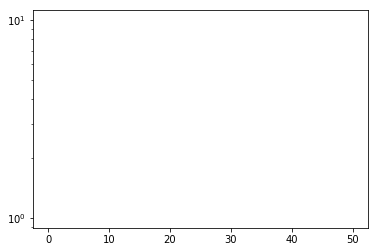

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
Nu=i+1

print(len(rnpf[0,:]))
print(len(rnpf))
print(Nu)
print(len(urange))
plt.plot(vrange,np.abs(dphinpvf[0]))
plt.plot(vrange,np.abs(dphinpvf[1]))
plt.yscale('log')
plt.show()
print(dphinpvf)
#rnpf[i+1][j+1]=answer[0]
#phinpf[i+1][j+1]=answer[1]
#signpf[i+1][j+1]=answer[2]
#massnpf[i+1][j+1]=answer[3]
#drunp[i+1][j+1]=answer[4]
#dsigunp[i+1][j+1]=answer[5]

In [12]:
#print(drnpvf[1,:])
#=> drnpvf,drnpuf,rnpf,signpf are NOT the problem
#print(dsignpuf[0,:])
#print(dphinpuf[1,:])

#print(drnpvf[0,:])


###wrong arrays###
#print(dsignpuf[1,:])
#print(dphinpuf[1,:])

In [13]:
switch=0.0
np.save('rnputil',np.array([Nu*Nv,Nu,Nv,ru0,dr0v,M0,Q,Lambda,wHD,switch,vbdytype]))
np.save('urange',urange)
np.save('vrange',vrange)

In [14]:
stop = timeit.default_timer()

In [15]:
acttime=stop - start

numpoints=Nu*Nv*uscal



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttimef=(acttime-predtime)/60

exttime=format(abs((acttime-predtime)/60),'.2f')
if exttimef>0.0:
    print("Took "+str(exttime)+" more minutes")
if exttimef<0.0:
    print("Took "+str(exttime)+" less minutes")
if exttimef==0.0:
    print("Took exactly the right time!!!!")

30.546450862995698 seconds
0.5091075143832616 minutes
0.008485125239721027 hours
17375000 points
568805.8517151092 points per second
Took 0.46 more minutes


conv=False
j=0
tempanswer=[]
    while conv==False:
        dv=TempTolv*dv0
        jcount=1
        while j<Nv-1:
            j1=mth.ceil(jcount*TempTolv)
            j2=mth.floor(jcount*TempTolv)
            answer=dnu.x4giveralt(0,j+mth.ceil((jcount-1)*TempTolv),du,dv*TempTolv,rnpf,phinpf,signpf,massnpf,M0,Q,Lambda,datatype)
            rnpf[1][j+j1]=answer[0]
            phinpf[1][j+j1]=answer[1]
            signpf[1][j+j1]=answer[2]
            massnpf[1][j+j1]=answer[3]
            #drunptemp[j+1]=answer[4]
            dsigunpv=answer[5]
            jcount=(jcount+1)**(0**j2)
            j=j+j2
        
        if np.abs(tempanswer[0]-answer[0])/answer[0]>0.01 or not tempanswer:
            tempanswer=answer
            TempTol=TempTolv/2
            
        else:
            conv=True
            

In [ ]:
''